# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import pickle
from datetime import date
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Create global dictionaries which we use for mapping complex strings to easy to use integer values
offer_id_global_dict = {}
offer_type_global_dict = {}

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Data Cleaning
First of all the datasets shall be cleaned. Therefore individual methods will be defined taking care about the 3 sets - Portfolio, Profile & Transcript.

In [6]:
def get_simple_offer_id(offer_id):
    '''
    Get simplified version of the original offer_id & create dict entry if not existing in the global offer_id_dict.
    
    INPUT:
    offer_id (string): the original offer id string
    
    OUTPUT:
    offer_id_simple (int): simplified version of the offer id string
    
    '''
    
    # When the offer_id is not in the global_dict already add it
    if offer_id not in offer_id_global_dict.keys():
        offer_id_global_dict[offer_id] = len(offer_id_global_dict)
 
     # Get the simple value of the offer_id string which is basically the value stored in the global dict for the original offer_id as key
    offer_id_simple = offer_id_global_dict[offer_id]
    
    return offer_id_simple
    

In [7]:
def get_simple_offer_type(offer_type):
    '''
    Get simplified version of the original offer_type & create dict entry if not existing in the global offer_type_dict.
    
    INPUT:
    offer_type (string): the original offer type string
    
    OUTPUT:
    offer_type_simple (int): simplified version of the offer type string (integer)
    
    '''
    
    # When the offer_type is not in the globa_dict already add it
    if offer_type not in offer_type_global_dict.keys():
        offer_type_global_dict[offer_type] = len(offer_type_global_dict)
 
    
    # Get the simple value of the offer_type string which is basically the value stored in the global dict for the original offer_type as key
    offer_type_simple = offer_type_global_dict[offer_type]
    
    return offer_type_simple

In [8]:
def clean_portfolio(portfolio):
    '''
    Clean the portfolio dataframe
    
    INPUT:
    portfolio (pandas dataframe): the original portfolio dataframe
    
    OUTPUT:
    portfolio_clean (pandas dataframe): the cleaned portfolio dataframe
    
    '''
    
    # Split channels and create dummy variables for them
    dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel', prefix_sep='_').sum(level=0)
    
    # Concat the dummie columns 
    portfolio_clean = pd.concat([portfolio, dummies], axis=1)
    portfolio_clean.drop(['channels'], axis=1, inplace=True)
    
    # Calculate relative difficulty
    portfolio_clean['difficulty'] = portfolio['difficulty'] / portfolio['difficulty'].max()
    
    # Rebase duration column to hours instead of days
    portfolio_clean['duration'] = portfolio['duration']*60
    
    # Replace complex id string by more easy ones
    offer_ids = []
    for offer_id in portfolio['id']:
        offer_ids.append(get_simple_offer_id(offer_id))
            
    portfolio_clean['offer_id'] = offer_ids
    portfolio_clean.drop(['id'], axis=1, inplace=True)
    
    # Replace complex offer_type string by more easy ones
    offer_types = []
    for offer_type in portfolio['offer_type']:
        offer_types.append(get_simple_offer_type(offer_type))
        
    portfolio_clean['offer_type'] = offer_ids
    
    # Calculate relative reward
    portfolio_clean['reward'] = portfolio['reward'] / portfolio['reward'].max()
    
    return portfolio_clean

In [9]:
print("Portfolio Dataframe before cleaning: ")
portfolio.head()

Portfolio Dataframe before cleaning: 


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [10]:
portfolio_clean = clean_portfolio(portfolio)
print("Portfolio Dataframe after cleaning: ")
portfolio_clean.head()

Portfolio Dataframe after cleaning: 


,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_id
0,0.50,420,0,1.0,1,1,1,0,0
1,0.50,300,1,1.0,1,1,1,1,1
2,0.00,240,2,0.0,1,1,0,1,2
3,0.25,420,3,0.5,1,1,0,1,3
4,1.00,600,4,0.5,1,0,0,1,4


In [11]:
def clean_profile(profile):
    '''
    Clean the profile dataframe
    
    INPUT:
    profile (pandas dataframe): the original profile dataframe
    
    OUTPUT:
    profile_clean (pandas dataframe): the cleaned profile dataframe
    
    '''
    
    # Copy profile df
    profile_clean = profile
    
    # Replace value 118 in age with NaN
    profile_clean['age'] = profile['age'].mask(profile['age'] == 118, np.nan)
    
    # Drop rows containing any NaN values
    profile_clean = profile.dropna()
    
    # Calculate the number of days a person is a member
    member_days = []
    for date_int in profile_clean['became_member_on']:
        # Convert integer date to datetime date
        date_datetime = date(int(str(date_int)[:4]), int(str(date_int)[4:6]), int(str(date_int)[6:]))
        
        # Calculate diff to today in days
        diff = date.today() - date_datetime
        days_to_today = diff.days
        
        # Insert to array
        member_days.append(days_to_today)
    
    # Insert new column to profile df called membershipdays containing the days a member is already on board
    profile_clean['membershipdays'] = member_days
    
    return profile_clean

In [12]:
print("Profile Dataframe before cleaning: ")
profile.head()

Profile Dataframe before cleaning: 


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile_clean = clean_profile(profile)
print("Portfolio Dataframe after cleaning: ")
profile_clean.head()

Portfolio Dataframe after cleaning: 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,became_member_on,gender,id,income,membershipdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2148
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2215
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1863
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1939
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2029


In [14]:
def clean_transcript(transcript):
    '''
    Clean the transcript dataframe
    
    INPUT:
    transcript (pandas dataframe): the original transcript dataframe
    
    OUTPUT:
    offer_df (pandas dataframe): offer related transaction stored in transcript dataframe
    
    '''
    # Extract all transactions which are offer related
    offer_df = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # Create new column called "offer_id" based on the offer_ids stored within the value field
    offer_df['offer_id'] = offer_df['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])


    return offer_df
    

In [15]:
offer_df = clean_transcript(transcript)
offer_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


# Data Exploration
Next, lets see what the data can tell us about customers of starbucks and their behavior and reaction to promotions and offers.

In [16]:
def data_exploration(profile_clean):
    '''
    Create meaningful plots about the data in order to get an idea about the starbucks customer.
    
    INPUT:
    profile_clean (pandas dataframe): the cleaned profile dataframe
    
    OUTPUT:
    -
    
    '''
    
    # Calculate the frequency a certain age value appears
    age_counts = profile_clean['age'].value_counts()
    
    # Create a bar chart
    plt.bar(age_counts.index, age_counts.values)
    
    # Add labels
    plt.title('Frequency of Starbucks members ages')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()
    
    # Create a bar chart
    plt.hist(profile_clean['membershipdays'], bins=500)
    
    # Add labels
    plt.title('How long did members become members?')
    plt.xlabel('Membershipdays')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()
    
    # What is the income of Starbucks members?
    plt.hist(profile_clean['income'], bins=80)
    
    # Add labels
    plt.title('Distribution of Starbucks customers income')
    plt.xlabel('Income')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

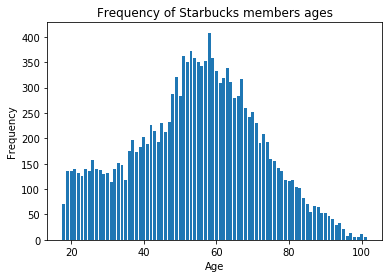

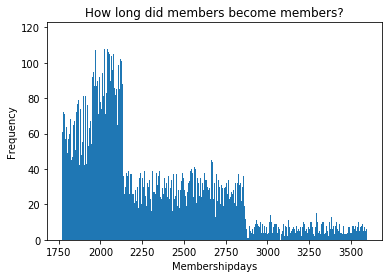

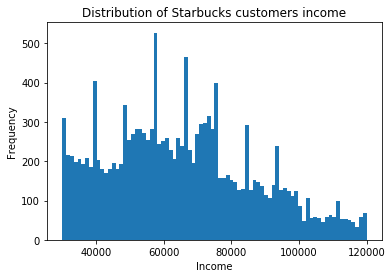

In [17]:
data_exploration(profile_clean)

In [18]:
profile_clean.describe()

,age,became_member_on,income,membershipdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,2294.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,1772.000000
25%,42.000000,2.016052e+07,49000.000000,1980.000000
50%,55.000000,2.017080e+07,64000.000000,2130.000000
75%,66.000000,2.017123e+07,80000.000000,2569.000000
max,101.000000,2.018073e+07,120000.000000,3595.000000


# Data Modeling
In the data modeling section a user_item_matrix shall be created and split into a train and a test set.
The training set shall be used for creating a user_latent_feature matrix as well as a latent_feature_offer matrix.
The test set shall be used for validation of the created matrices.
Finally we can use the created matrix pair for predicting the behavior of users we have in our database.
For cope with the cold start problem - basically for new users - we will find the top offers based on revenue and provide them as recommendation

Finally we will have the option to find out how already known users will react on certain offers as well as provide recommendations also to new users.

In [19]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    
    return user_item_matrix

In [26]:
# Lets start creating a full user_item_matrix. The matrix will be saved into a file for loading it afterwards in order to speed up the processing.
user_item_matrix = create_user_item_matrix(offer_df, 'userItemMatrix.p')
user_item_matrix.head()

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [38]:
# Split the full dataset into a training and a test dataset. We will use a 70/30 split here.
train_size = int(offer_df.shape[0]*0.7)
train_offer_df = offer_df[:train_size]

test_size = offer_df.shape[0]-int(offer_df.shape[0]*0.7)
test_offer_df = offer_df[train_size:]

print(train_offer_df.shape)
print(test_offer_df.shape)

(117306, 5)
(50275, 5)


In [24]:
# Create a user_item_matrix only for training & save it into a file
train_df = create_user_item_matrix(train_offer_df, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [39]:
# Create a user_item_matrix for validation & save it into a file
test_df = create_user_item_matrix(test_offer_df, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [41]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [42]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [68]:
# Since the creation of the user-item matrix variables takes quite a lot of time one can use the pre-processesd variables stores in the .p files
# Simply remove the '#' in front of the next lines

user_item_matrix = pd.read_pickle('userItemMatrix.p')
# train_df = pd.read_pickle('train_df.p')
# test_df = pd.read_pickle('train_df.p')

In [45]:
def FunkSVD(complete_mat, latent_features=15, learning_rate=0.005, iters=200):
    '''
    This function performs matrix factorization using a basic form of FunkSVD
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat 

In [46]:
# Convert train data to numpy array
train_data_np = np.array(train_df)

# Use the train data & the FunkSVD algorithm to create user and offer matrices
user_mat, offer_mat = FunkSVD(train_data_np)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.309174
2 		 0.267569
3 		 0.267207
4 		 0.266831
5 		 0.266450
6 		 0.266062
7 		 0.265669
8 		 0.265268
9 		 0.264860
10 		 0.264445
11 		 0.264020
12 		 0.263587
13 		 0.263144
14 		 0.262690
15 		 0.262225
16 		 0.261748
17 		 0.261258
18 		 0.260754
19 		 0.260236
20 		 0.259701
21 		 0.259149
22 		 0.258579
23 		 0.257989
24 		 0.257379
25 		 0.256746
26 		 0.256089
27 		 0.255407
28 		 0.254699
29 		 0.253961
30 		 0.253194
31 		 0.252394
32 		 0.251560
33 		 0.250691
34 		 0.249783
35 		 0.248835
36 		 0.247845
37 		 0.246811
38 		 0.245731
39 		 0.244602
40 		 0.243423
41 		 0.242191
42 		 0.240905
43 		 0.239562
44 		 0.238160
45 		 0.236698
46 		 0.235175
47 		 0.233587
48 		 0.231936
49 		 0.230218
50 		 0.228433
51 		 0.226580
52 		 0.224658
53 		 0.222668
54 		 0.220609
55 		 0.218481
56 		 0.216284
57 		 0.214020
58 		 0.211688
59 		 0.209290
60 		 0.206827
61 		 0.204300
62 		 0.201712
63 		 0.199064
64 		 0

In [47]:
# Use the train data & the FunkSVD algorithm to create user and offer matrices
# This time with adapted paramters - latent_features = 12
user_mat_12, offer_mat_12 = FunkSVD(train_data_np, latent_features=12, learning_rate=0.005, iters=200)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.302184
2 		 0.266490
3 		 0.266088
4 		 0.265678
5 		 0.265264
6 		 0.264848
7 		 0.264427
8 		 0.264004
9 		 0.263576
10 		 0.263144
11 		 0.262707
12 		 0.262266
13 		 0.261819
14 		 0.261367
15 		 0.260909
16 		 0.260444
17 		 0.259972
18 		 0.259493
19 		 0.259006
20 		 0.258510
21 		 0.258005
22 		 0.257491
23 		 0.256965
24 		 0.256429
25 		 0.255880
26 		 0.255318
27 		 0.254743
28 		 0.254152
29 		 0.253546
30 		 0.252923
31 		 0.252282
32 		 0.251622
33 		 0.250941
34 		 0.250238
35 		 0.249512
36 		 0.248762
37 		 0.247985
38 		 0.247181
39 		 0.246348
40 		 0.245483
41 		 0.244587
42 		 0.243655
43 		 0.242688
44 		 0.241683
45 		 0.240638
46 		 0.239552
47 		 0.238422
48 		 0.237247
49 		 0.236025
50 		 0.234755
51 		 0.233435
52 		 0.232063
53 		 0.230638
54 		 0.229159
55 		 0.227624
56 		 0.226033
57 		 0.224385
58 		 0.222679
59 		 0.220915
60 		 0.219092
61 		 0.217212
62 		 0.215274
63 		 0.213279
64 		 0

In [48]:
# Use the train data & the FunkSVD algorithm to create user and offer matrices
# This time with adapted paramters - latent_features = 12
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=200)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.281684
2 		 0.268426
3 		 0.267592
4 		 0.266757
5 		 0.265922
6 		 0.265086
7 		 0.264249
8 		 0.263412
9 		 0.262574
10 		 0.261735
11 		 0.260896
12 		 0.260056
13 		 0.259215
14 		 0.258374
15 		 0.257531
16 		 0.256688
17 		 0.255844
18 		 0.254999
19 		 0.254152
20 		 0.253305
21 		 0.252456
22 		 0.251605
23 		 0.250753
24 		 0.249900
25 		 0.249044
26 		 0.248187
27 		 0.247327
28 		 0.246466
29 		 0.245602
30 		 0.244735
31 		 0.243865
32 		 0.242992
33 		 0.242116
34 		 0.241237
35 		 0.240354
36 		 0.239467
37 		 0.238575
38 		 0.237679
39 		 0.236778
40 		 0.235872
41 		 0.234961
42 		 0.234043
43 		 0.233120
44 		 0.232190
45 		 0.231253
46 		 0.230309
47 		 0.229358
48 		 0.228398
49 		 0.227430
50 		 0.226453
51 		 0.225467
52 		 0.224472
53 		 0.223466
54 		 0.222450
55 		 0.221423
56 		 0.220384
57 		 0.219334
58 		 0.218272
59 		 0.217197
60 		 0.216110
61 		 0.215009
62 		 0.213894
63 		 0.212765
64 		 0

In [49]:
def predict_customer_behavior(user_matrix, offer_matrix, user_id, offer_id):
    '''
    This function calculates a predicted value for the customer behavior in case of sending a specific offer.
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("No prediction possible - It looks like one of these items does not exist in our current database.")
    
        return None

In [77]:
def test_train_results(test_df, user_mat, offer_mat):
    '''
    Measure the squared errors for the predictions
    
    INPUT:
    test_df - the user_item_matrix used for validation
    user_mat - the resulting user-latent-feature-matrix of FunkSVD 
    offer_mat - the resulting latent-feature-offer-matrix of FunkSVD 
    
    OUTPUT:
    validation_result - (float) sum of squared errors normalized by dividing through number of completed offers
    
    '''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_customer_behavior(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_customer_behavior(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    validation_result = sse_accum / num_complete
    
    return validation_result

In [62]:
print("Validation results for 15 latent features: ", test_train_results(test_df, user_mat, offer_mat))
print("Validation results for 12 latent features: ", test_train_results(test_df, user_mat_12, offer_mat_12))
print("Validation results for 5 latent features: ", test_train_results(test_df, user_mat_5, offer_mat_5))

Validation results for 15 latent features:  0.330054634751
Validation results for 12 latent features:  0.32440120709
Validation results for 5 latent features:  0.289019463861


In [87]:
def offer_ranking(user_item_matrix):
    '''
    Find the best offers with respect to revenue based on all customers
    
    INPUT:
    user_item_matrix - full blown user_item_matrix (not splitted)
    
    OUTPUT:
    offer_value - (matrix) matrix containing offer_id and the respective "revenue" orderd from high to low
    '''

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    #print(offer_value)
    
    return offer_value

In [84]:
def recommend_offer(user_id, user_mat, offer_mat):
    '''
    Recommend offers for users
    
    INPUT:
    user_id - (string) user id for which the recommendation shall be made
    user_mat - the resulting user-latent-feature-matrix of FunkSVD 
    offer_mat - the resulting latent-feature-offer-matrix of FunkSVD   
    '''
    
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_customer_behavior(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = offer_ranking(user_item_matrix)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [85]:
# Select example user
user_id_example = train_df.index[10]

# recommend offer for a particular user
recommend_offer(user_id_example, user_mat, offer_mat)

recommend offer for user  0056df74b63b4298809f0b375a304cf4
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  1.32
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  1.17
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.14
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  1.05
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.89
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.7
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.34
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.07


In [88]:
# Try recommendation for new user - "cold start problem"
recommend_offer('unknown_user_id', user_mat, offer_mat)

Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7
